# Competition Tutorial

In this tutorial, you will learn how to run inference on the SF20K benchmark using a pretrained vision-language model. Specifically, you will:
1. Load the SF20K competition dataset
2. Download a short film from YouTube
3. Run inference using Qwen2.5-VL
4. Evaluate the model's prediction with LLM-QA-Eval metric

In [1]:
import subprocess
import cv2
import ast
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor, pipeline
from qwen_vl_utils import process_vision_info

[2025-06-23 13:08:59,009] [INFO] [real_accelerator.py:222:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/users/ghermi/miniconda3/envs/movie_star/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/users/ghermi/miniconda3/envs/movie_star/compiler_compat/ld: warning: librt.so.1, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/users/ghermi/miniconda3/envs/movie_star/compiler_compat/ld: warning: libstdc++.so.6, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/users/ghermi/miniconda3/envs/movie_star/compiler_compat/ld: warning: libm.so.6, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/users/ghermi/miniconda3/envs/movie_star/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `std::runtime_error::~runtime_error()@GLIBCXX_3.4'
/users/ghermi/miniconda3/envs/movie_star/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `__gxx_personality_v0@CXXABI_1.3'
/users/

## 1. Load the SF20K competition dataset

Let's import data from the csv file. The dataframe contains 4 columns:
- question_id (str): Question ID
- video_id (str): YouTube video ID (i.e., 'https://www.youtube.com/watch?v=<VIDEO_ID>)
- question (str): A question about the video
- answer (str): A short and concise answer

There are 538 questions and 50 videos (average: 10.8 questions / video). 'video_id' corresponds to the YouTube ID, videos are accessible at the following link: "https://www.youtube.com/watch?v=<VIDEO_ID>".

In [2]:
df = pd.read_csv('test_expert.csv')

print(f"Number of questions: {df.question_id.nunique()}")
print(f"Number of videos: {df.video_id.nunique()}")
print(f"Average number of questions per video: {df.question_id.nunique() / df.video_id.nunique():.1f}")

df.head()

Number of questions: 538
Number of videos: 50
Average number of questions per video: 10.8


,question_id,video_id,question,answer
0,1AvyUWUKCw8_01,1AvyUWUKCw8,What is VR truly used for?,War.
1,1AvyUWUKCw8_02,1AvyUWUKCw8,What does the protagonist initially think they...,Playing VR games.
2,1AvyUWUKCw8_03,1AvyUWUKCw8,How does the protagonist know the truth?,The device was destroyed by a man.
3,1AvyUWUKCw8_04,1AvyUWUKCw8,Why did the protagonist choose to shoot himself?,Because he realized that he was not playing ga...
4,1AvyUWUKCw8_05,1AvyUWUKCw8,Who did the protagonist ultimately meet?,Another person playing VR games.


Let's check a sample.

In [3]:
idx = 0
sample = df.iloc[idx]

video_id = sample['video_id']
video_url = f"https://www.youtube.com/watch?v={video_id}"
question = sample['question']
answer = sample['answer']

print(f"Question ID: {sample['question_id']}")
print(f"Video ID: {video_id}")
print(f"Video URL: {video_url}")
print(f"Question: {question}")
print(f"Answer: {answer}")

Question ID: 1AvyUWUKCw8_01
Video ID: 1AvyUWUKCw8
Video URL: https://www.youtube.com/watch?v=1AvyUWUKCw8
Question: What is VR truly used for?
Answer: War.


## 2. Download a short film from YouTube

In this section, we will download a short film from YouTube using the yt-dlp library. To install the library, use this command line: 'pip install yt-dlp'.

We will download the video in .mp4 format and with the 360p resolution. The video will be saved as '<VIDEO_ID>.mp4'.

In [4]:
video_url = f"https://www.youtube.com/watch?v={video_id}"
video_path = f"{video_id}.mp4"
cmd_line = f"yt-dlp -f 'bestvideo[height<=360]+bestaudio/best[height<=360]' -i -o {video_path} --merge-output-format mp4 {video_url}"
subprocess.run(cmd_line, shell=True)

[youtube] Extracting URL: https://www.youtube.com/watch?v=1AvyUWUKCw8
[youtube] 1AvyUWUKCw8: Downloading webpage
[youtube] 1AvyUWUKCw8: Downloading tv client config
[youtube] 1AvyUWUKCw8: Downloading player 9fe2e06e-main
[youtube] 1AvyUWUKCw8: Downloading tv player API JSON
[youtube] 1AvyUWUKCw8: Downloading ios player API JSON
[youtube] 1AvyUWUKCw8: Downloading m3u8 information
[info] 1AvyUWUKCw8: Downloading 1 format(s): 243+251
[download] 1AvyUWUKCw8.mp4 has already been downloaded


CompletedProcess(args="yt-dlp -f 'bestvideo[height<=360]+bestaudio/best[height<=360]' -i -o 1AvyUWUKCw8.mp4 --merge-output-format mp4 https://www.youtube.com/watch?v=1AvyUWUKCw8", returncode=0)

Below, we load 16 evenly sampled frames from the video and display them as an image grid.

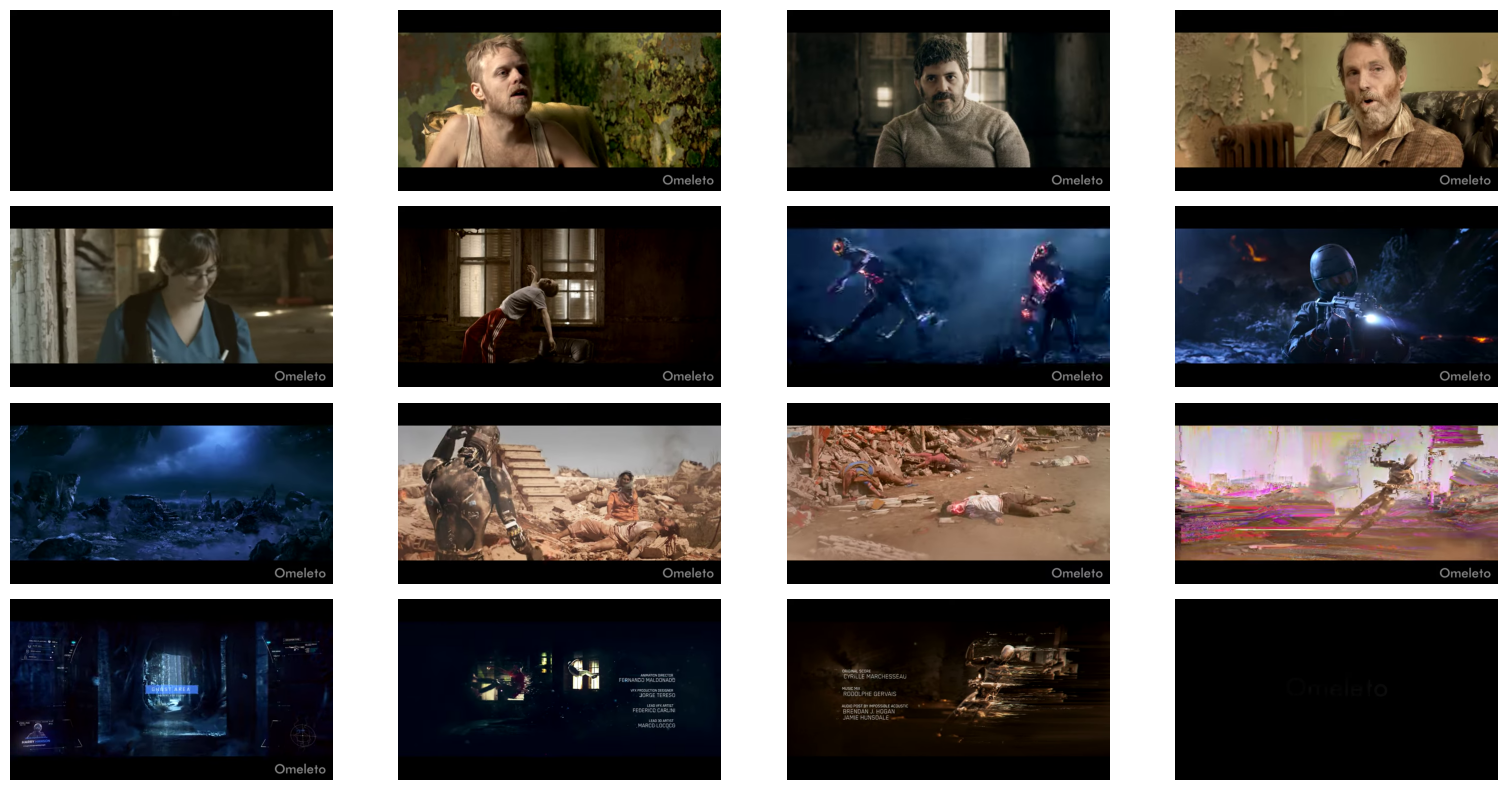

In [5]:
def load_video(video_path: str, num_frames: int = 16):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    indices = np.linspace(0, frame_count - 1, num_frames, dtype=int)

    frames = []
    for idx in indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        success, frame = cap.read()
        if success:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        else:
            frames.append(np.zeros_like(frames[-1] if frames else np.zeros((64, 64, 3), dtype=np.uint8)))

    cap.release()
    return frames

def display_frames(frames: list, n_rows: int, n_cols: int):
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 2))
    for i, ax in enumerate(axs.flat):
        ax.imshow(frames[i])
        ax.axis("off")
    plt.tight_layout()
    plt.show()

num_frames = 16
frames = load_video(video_path, num_frames=num_frames)
display_frames(frames, 4, 4)

We also prepare the subtitles coresponding to the short films. Subtitles for test videos are available at the following URL: https://github.com/ridouaneg/sf20k/data/test_subtitles.csv.

In [6]:
df_subs = pd.read_csv('test_subtitles.csv')
subtitles = '\n'.join(df_subs[(df_subs.video_id == video_id)].text.tolist())
print(subtitles)

## 3. Run inference using Qwen2.5-VL

We will now run inference using **Qwen2.5-VL-3B-Instruct**, a state-of-the-art vision-language model released by Alibaba. The model is available on Hugging Face (https://huggingface.co/Qwen/Qwen2.5-VL-3B-Instruct). Ensure you downloaded the model and specify the path below (model_path). We load the model using the transformers library.

In [7]:
model_path = "Qwen/Qwen2.5-VL-3B-Instruct"
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_path,
    torch_dtype="auto",
    device_map="auto"
)
processor = AutoProcessor.from_pretrained(model_path)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


To limit variability, we use a fixed prompt for every vision-language models, inspired by Gemini. It is written as follows:

In [8]:
prompt = (
    "You will be given a question about a movie. Try to answer it based on the subtitles and the frames from the movie.\n\n"
    f"Subtitles:\n{subtitles}\n\n"
    f"Question: {question}\n\n"
    "Answer it shortly and directly without repeating the question."
)
print(prompt)

You will be given a question about a movie. Try to answer it based on the subtitles and the frames from the movie.

Subtitles:


Question: What is VR truly used for?

Answer it shortly and directly without repeating the question.


Let's now get the prediction!

In [9]:
# Format the prompt
messages = [{"role": "user", "content": [
    {"type": "video", "video": video_path, "nframes": num_frames},
    {"type": "text", "text": prompt}
]}]

text = processor.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)

# Process the visual information
image_inputs, video_inputs, video_kwargs = process_vision_info(messages, return_video_kwargs=True)

# Prepare the inputs
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
    **video_kwargs,
)

# Generate the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
prediction = processor.batch_decode(
    generated_ids_trimmed,
    skip_special_tokens=True,
    clean_up_tokenization_spaces=False,
)[0]
print(prediction)

qwen-vl-utils using decord to read video.
video_reader_backend decord error, use torchvision as default, msg: [13:09:42] /github/workspace/src/video/ffmpeg/threaded_decoder.cc:104: Check failed: run_.load()
/users/ghermi/miniconda3/envs/movie_star/lib/python3.9/site-packages/torchvision/io/_video_deprecation_warning.py:5: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/users/ghermi/miniconda3/envs/movie_star/lib/python3.9/site-packages/transformers/generation/utils.py:2347: UserWarning: You are calling .generate() with the `input_ids` being on a 

To play video games.


In [10]:
del model, processor

## 4. Run evaluation with LLM-QA-Eval metric

In this section, we will run evaluation with the LLM-QA-Eval metric on the current sample. Let's look at the prediction again.

In [11]:
print(f"Question: {question}")
print(f"Answer: {answer}")
print(f"Prediction: {prediction}")

Question: What is VR truly used for?
Answer: War.
Prediction: To play video games.


The **LLM-QA-Eval** metric is a LLM-based evaluation score. Given the question, we use 'Llama-3.1-8B-Instruct' to compare the ground-truth and predicted answers. The LLM outputs a score between 0 and 5. The overall metric is the average score over all samples. Let's load the LLM using Hugging Face transformers library. You should download the model (https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct) and specify the path below (model_path).

In [12]:
model_path = "meta-llama/Llama-3.1-8B-Instruct"
model = pipeline("text-generation", model=model_path)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:0


Let's get the score!

In [13]:
SYSTEM_PROMPT = (
    "You are an intelligent chatbot designed for evaluating the correctness of generative outputs for question-answer pairs. "
    "Your task is to compare the predicted answer with the correct answer and determine if they match meaningfully. Here's how you can accomplish the task:\n"
    "------\n"
    "##INSTRUCTIONS:\n"
    "- Focus on the meaningful match between the predicted answer and the correct answer.\n"
    "- Consider synonyms or paraphrases as valid matches.\n"
    "- Evaluate the correctness of the prediction compared to the answer."
)

USER_PROMPT = (
    "Please evaluate the following video-based question-answer pair:\n\n"
    f"Question: {question}\n"
    f"Correct Answer: {answer}\n"
    f"Predicted Answer: {prediction}\n\n"
    "Provide your evaluation only as a yes/no and score where the score is an integer value between 0 and 5, with 5 indicating the highest meaningful match. "
    "Please generate the response in the form of a Python dictionary string with keys 'pred' and 'score', where value of 'pred' is a string of 'yes' or 'no' and value of 'score' is in INTEGER, not STRING. "
    "DO NOT PROVIDE ANY OTHER OUTPUT TEXT OR EXPLANATION. Only provide the Python dictionary string. "
    "For example, your response should look like this: {'pred': 'yes', 'score': 4}."
)

prompt = f"<<SYS>>\n{SYSTEM_PROMPT}\n<</SYS>>\n\n[INST] {USER_PROMPT} [/INST]"

output = model(prompt, max_new_tokens=100, do_sample=False)
output = output[0]["generated_text"].removeprefix(prompt).strip()

try:
    score = ast.literal_eval(output)["score"]
except:
    score = 0

print(f"Score: {score}")

/users/ghermi/miniconda3/envs/movie_star/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/users/ghermi/miniconda3/envs/movie_star/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Score: 0


Finally, here is the expected format for the submission file: a .json file containing a list of dictionary. Each dictionary is contains the following keys: question_id, video_id, question, answer, prediction. The submission file should be submitted on the eval.ai platform: https://eval.ai/web/challenges/challenge-page/2560/submission.

In [14]:
data = [
    {
        "question_id": sample['question_id'],
        "video_id": sample['video_id'],
        "question": sample['question'],
        "answer": sample['answer'],
        "prediction": prediction,
    }
]
json.dump(data, open('submission.json', 'w'))

**To go further:**
- To download all videos at once, use the following script: 'scripts/download_videos.py'
- You can run inference and evaluation on the whole dataset using the following scripts: 'scripts/run_infernce.py' and 'scripts/evaluation.py'
- Don't hesitate to play with different models and hyperparameters (e.g., number of frames, input modality), or even implement your own method!
- More annotations are available in the GitHub (https://github.com/ridouaneg/sf20k/tree/main/data), including shot boundaries and face tracks.